In [3]:
import tensorflow as tf
from tensorflow.python.keras.applications.vgg19 import VGG19

In [4]:
model = VGG19(include_top = False , weights = 'imagenet')  #Get the weights that were trained on imagenet. Dont include the last layer (Classification layer)
model.trainable = False #Freeze the weights
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [13]:
from tensorflow.python.keras.preprocessing.image import load_img , img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model

import numpy as np
from numpy import shape
import matplotlib.pyplot as plt

%matplotlib inline  

In [70]:
#Preprocess image to feed into VGG19 Model
def load_preprocess(image_path):
  img = load_img(image_path)
  img = img_to_array(img)   #Convert from image to array
  img = preprocess_input(img)   #Using the vgg19 function, it preprocesses the image such that it has a shape compatible with the model
  img = np.expand_dims(img,axis=0)  #As 4D array is expected when feeding to model, you add a new dimension with the added dimension (which is the first dim, hence axis=0) being the batch size (1 in this case as only one image), you expand_dims (will give a new dimension of value =1)
  return img

In [78]:
content = load_preprocess('content.jpg')
style = load_preprocess('style.jpg')

In [71]:
 #Do the opposite of preprocessing, so you can convert and view the generated image in a human understandable manner  (De-normalizing in that sense)
 #This is necessary because you normalized (0-1) the pixel values during preprocessing. 
 #Hence, in order to view the image properly you need to get the pixel values back to the normal form (0-255)
 def deprocess(img):
   img[:,:,0] += 103.939
   img[:,:,1] += 116.779
   img[:,:,2] += 123.68
   img = img[:,:,::-1]

   img = np.clip(img,0,255).astype('uint8')  #all values below 0 will become 0. All values above 255 will become 255. This corresponds to the pixel values. Change type to float32
   return img

In [75]:
def display_image(img):
  if len(img.shape) == 4:  #Because we converted a 3D array to a 4D array with expand_dims. We need a 3D array in order to view it so we convert it back to 3D
    img = np.squeeze(img, axis= 0 )  #Remove the first dimension. Squeeze only removes dimensions with value =1

  img = deprocess(img)
  plt.grid(False)
  plt.imshow(img)
  return

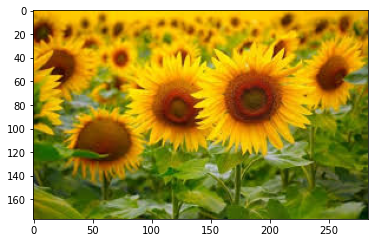

In [77]:
display_image(content)

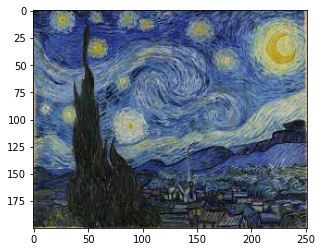

In [79]:
display_image(style)

In [80]:
content_layer = 'block5_conv2'

style_layers = [
                'block1_conv1',
                'block3_conv1',
                'block5_conv1'
]

In [96]:
#The model specifically for the intermediate layer (To get the content cost)
content_model = Model(
    inputs = model.input,  #This is the normal inputs fed to the VGG19 model
    outputs = model.get_layer(content_layer).output  #This will give the output activations of the specified layer (instead of the output usually being the last layer activation)
)

In [99]:
#Specify the models for computing the style cost. This will be a list of models corresponding to the 3 different layers you need for computing style cost
style_models = [Model(
    inputs = model.input,
    outputs = model.get_layer(name).output) for name in style_layers
]

In [91]:
def content_cost(content,generated):
  a_C = content_model(content)  #Get the 'block5_conv2' layer activations of the content image
  a_G = content_model(generated)
  cost = tf.reduce_mean(tf.square(a_C - a_G))  #Get the square of a_c - a_G . Then, get the mean of all elements in the tensor using tf.reduce_mean  (This returns a single element)
  return cost

In [97]:
def gram_matrix(atv):  #Will take the activations as input
  n_C = int(atv.shape[-1])  #Get the number of feature maps for that layer
  temp = tf.reshape(atv,[-1,n_C]) #Reshape the tensor from [h,w,c] to [h*w,c]. remember that -1 here means that it will automatically find the value of first dimension such that the 2nd dimension can be n_C
  n_elements = tf.shape(temp)[0]  #This is the number of elements from h*w
  gram = tf.matmul(temp,temp,transpose_a = True)  #This will be a n_C by n_C matrix, which shows the correlation between different feature maps in the same layer. Remember: A layer is composed of multiple feature maps (aka kernels)
  n_elements = tf.cast(n_elements,tf.float32)  #Make n_elements of dtype float32
  return gram / n_elements   #To scale down the gram matrix to the number of elements it has 

In [100]:
#The weights of the cost from each individual model (Since you have 3 layers and hence 3 models)
#What this does is to set the weights to 1/3 per model, such that each model has an equal weightage
weight = 1. /len(style_models)

def style_cost(style, generated):
  J_style = 0  #The total style cost. This will be the weighted sum of the individual costs of all the 3 models 

  for style_model in style_models:  #Loop through all 3 models in the style models list (That contains 3 model objects)
    a_S = style_model(style)
    a_G = style_model(generated)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    current_cost = tf.reduce_mean(tf.square(GS - GG))  #To calculate the style cost for the current iteration
    J_style += current_cost * weight  #Add the weighted current_cost to the total style cost

  return J_style

In [107]:
import time
generated_imgs = []

def training_loop(content_path, style_path, iterations = 20 , alpha = 10. , beta = 20.):
  content = load_preprocess(content_path)
  style = load_preprocess(style_path)

  generated = tf.Variable(content,dtype=tf.float32)  #Create a generated image that is obtained from the content image
  opt = tf.optimizers.Adam(learning_rate = 7.)
  best_cost = 1e12  #Initialize to a very large number first
  best_image = None

  start_time = time.time()

  for i in range(iterations):
    with tf.GradientTape() as tape:
      J_content = content_cost(content,generated)
      J_style = style_cost(style,generated)
      J_total = alpha * J_content + beta * J_style  #Weighted sum of total cost

    grads = tape.gradient(J_total,generated)  #Calculate the gradient of the loss function with respect to the generated image
    opt.apply_gradients([(grads,generated)])  #Using Adam optimizer and the gradient calculated, update the generated image such that cost is minimized

    if J_total < best_cost:  #If the current generated image gives a lower cost as compared to previous values, you replace the best image with the current image and change the best_cost to the current cost
      best_cost = J_total
      best_image = generated.numpy()  #Since 'generated' is a tensor objct, you just want the numpy array (Which is basically the array form of the image)

    print(f'Cost at {i} iteration: {J_total}. Time elapsed: {time.time() - start_time}')
    
    generated_imgs.append(generated.numpy())  #Store all intermediate generated images (20, since you go through 20 iterations) inside this list

  return best_image

In [108]:
best_image = training_loop('content.jpg','style.jpg')

Cost at 0 iteration: 8759540736.0. Time elapsed: 12.136861562728882
Cost at 1 iteration: 4265850624.0. Time elapsed: 23.373985767364502
Cost at 2 iteration: 2994746112.0. Time elapsed: 34.58852815628052
Cost at 3 iteration: 2428722688.0. Time elapsed: 45.768635511398315
Cost at 4 iteration: 2143747840.0. Time elapsed: 56.95173406600952
Cost at 5 iteration: 1966343936.0. Time elapsed: 72.49153923988342
Cost at 6 iteration: 1801126272.0. Time elapsed: 83.69963359832764
Cost at 7 iteration: 1642483968.0. Time elapsed: 94.90699434280396
Cost at 8 iteration: 1505358080.0. Time elapsed: 106.14003658294678
Cost at 9 iteration: 1385009792.0. Time elapsed: 117.37355184555054
Cost at 10 iteration: 1276027520.0. Time elapsed: 128.64701175689697
Cost at 11 iteration: 1177339392.0. Time elapsed: 139.8765320777893
Cost at 12 iteration: 1090563712.0. Time elapsed: 151.12831211090088
Cost at 13 iteration: 1011219712.0. Time elapsed: 162.35396265983582
Cost at 14 iteration: 937364480.0. Time elapsed: 1

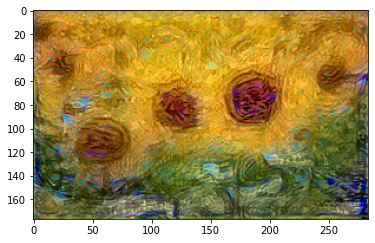

In [109]:
display_image(best_image)

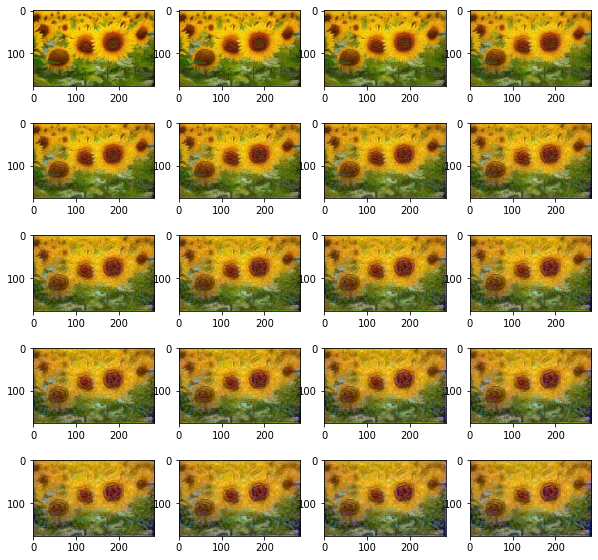

In [111]:
plt.figure(figsize = (10,10))

for i in range(20):
  plt.subplot(5,4,i+1)
  display_image(generated_imgs[i])

plt.show()